In [172]:
store = int(input("Enter Store Number to Begin analysis: "))

Enter Store Number to Begin analysis: 2


# Image Analysis

[array([179.154926  , 180.61554406, 174.27778986]), array([69.29314292, 71.75446097, 66.32052273])]


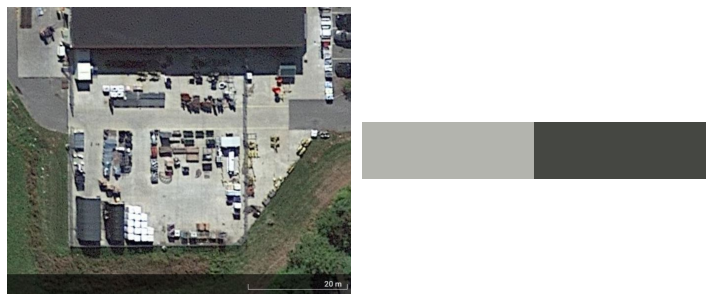

Empty lot pixels 80544


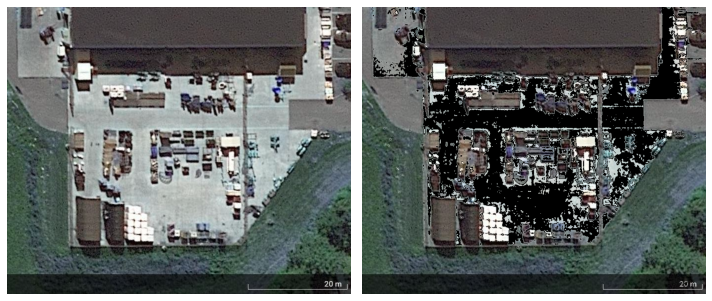

In [173]:
from sklearn.cluster import KMeans
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread("../AI-ML Tractor Analytics/SideLotImages/Scrub_Store_{}.JPG".format(store))
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

clt = KMeans(n_clusters=2)

def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()
    
def palette(clusters):
    colors = []
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        colors.append(centers)
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    print(list(colors))
    return palette, colors


# Light -1   Dark -0
def isLightOrDark(rgbColor=[0,128,255]):
    [r,g,b]=rgbColor
    hsp = math.sqrt(0.299 * (r * r) + 0.587 * (g * g) + 0.114 * (b * b))
    if (hsp>127.5):
        return 1
    else:
        return 0

clt_1 = clt.fit(rgb_img.reshape(-1, 3))
palette_out = palette(clt_1)
show_img_compar(rgb_img, palette_out[0])

light_color = None
for color in palette_out[1]:
    if isLightOrDark(color) == 1:
        light_color = color
        break

def color_diff1(c1,c2):
    r1,g1,b1 = c1
    r2,g2,b2 = c2
    d=sqrt((r2-r1)**2+(g2-g1)**2+(b2-b1)**2)
    if d < 100:
        return True
    return False

def color_diff(c1,c2):
    r1,g1,b1 = c1
    r2,g2,b2 = c2
    diff = 25
    if abs(r1-r2) < diff and abs(g1-g2) < diff and abs(b1-b2) < diff:
        return True
    return False

blank_image = np.zeros((img.shape[0],img.shape[1],3), np.uint8)
empty_lot_pixels = 0
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
#         print(image[i,j])
        x = img[i,j]
#         print(type(x))
        if color_diff(list(x),light_color):
#             print(img[i,j])
            empty_lot_pixels+=1
            blank_image[i,j] = [0,0,0]
        else:
            blank_image[i,j] = list(x)
            
print(f"Empty lot pixels {empty_lot_pixels}")
f, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(blank_image)
ax[0].axis('off') #hide the axis
ax[1].axis('off')
f.tight_layout()
plt.show()

# Scaling

Side Lot Number : 2
-----------------------

Scale distance = 202 px

Conversion: 1 sq.px = 10.1 sq.mtrs = 108.71538999999999 sq.feet
Source


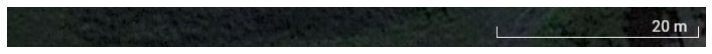

Contours


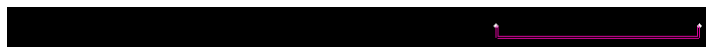



Total Available Area = 80544 * 108.715 = 8756372.372 sq.feet


In [182]:
import cv2 
import numpy as np
import random as rng
rng.seed(12345)

class SideLot:
    
    def __init__(self,image=2):
        src='/home/saketh/Documents/Hackathons/AI-ML Tractor Analytics/SideLotImages/Scrub_Store_{}.JPG'.format(image)
        self.src = src
        self.read_img()
        self.get_black()
    
    def read_img(self):
        self.image = cv2.imread(self.src)
        h = self.image.shape[0]
        self.image = self.image[h-40:]
        
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.median_blur = cv2.medianBlur(self.image,3)
        self.source = self.gray
        
    def get_black(self):
        c = np.uint8(0)
        a = np.array([[np.array([c,c,c])]*self.image.shape[1]]*self.image.shape[0])
        self.black = np.array(a)

    def findEdges(self,thresh_1=100,thresh_2=200,show=False):
        self.edged = cv2.Canny(self.source, thresh_1, thresh_2)
         

        self.contours, self.hierarchy = cv2.findContours(self.edged, 
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        
        
        if show:
            print('Canny Edges After Contouring')
            f, ax = plt.subplots(1, 1, figsize=(10,10))
            ax.imshow(self.edged)
            ax.axis('off') #hide the axis
            f.tight_layout()
            plt.show()
        
        return self.contours, self.hierarchy


analyser = SideLot(store)
contours, hierarchy = analyser.findEdges(400,800)
black = analyser.black

long_c = list()
min_thresh = 300
max_thresh = 1500

for i in contours:
    if i.shape[0] >= min_thresh and i.shape[0] <= max_thresh:
        long_c.append(i)

total_distance = 0

for i in long_c:
    a,b = np.min(i,axis=0)[0][0], np.min(i,axis=0)[0][1]
    c = np.max(i,axis=0)[0][0]
    #print(a,b,c,b)
    total_distance = total_distance + abs(a-c)
    cv2.drawContours(black, np.array([[[a,b]]]), 0, (255,255,255), 3)
    cv2.drawContours(black, np.array([[[c,b]]]), 0, (255,255,255), 3)

avg_distance = total_distance // len(long_c)

sq_mtrs = avg_distance/20
sq_ft = sq_mtrs*10.7639

print("Side Lot Number : {}\n-----------------------\n".format(store))
print("Scale distance = {} px\n".format(avg_distance))
print("Conversion: 1 sq.px = {} sq.mtrs = {} sq.feet".format(sq_mtrs,sq_ft))

for i in range(len(long_c)):
    #print(long_c[i].shape)
    y = long_c[i]
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(black, long_c, i, color, 1, cv2.LINE_8, hierarchy, 0)

print("Source")
f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow( analyser.image)
ax.axis('off') #hide the axis
f.tight_layout()
plt.show()
#cv2.imshow('Source', analyser.image)
print("Contours")
f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(black)
ax.axis('off') #hide the axis
f.tight_layout()
plt.show()

total_available_area = round(empty_lot_pixels*sq_ft,3)
print("\n\nTotal Available Area = {} * {} = {} sq.feet".format(empty_lot_pixels,round(sq_ft,3),total_available_area))

# Sales Forecasting

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime
from pathlib import Path

In [176]:
class LSTM_Final(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Final, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [177]:
def forecast_data(model,store):
    if model == "salesAnalyzer":
        PATH = "./predictions/salesAnalyzer/forecast/store_{}.csv".format(store)
        if not Path(PATH).is_file():
            print("Run Sales Analyzer Main File")
            
        forecast = pd.read_csv(PATH)
    elif model == "weatherAnalyzer":
        PATH = "./predictions/weatherAnalyzer/forecast/store_{}.csv".format(store)
        if not Path(PATH).is_file():
            print("Run Weather Analyzer Main File")
            
        forecast = pd.read_csv(PATH)
    elif model == "IBMCloud":
        PATH = "./IBM_Cloud/predictions/model-1/predictions.csv".format(store)
        if not Path(PATH).is_file():
            print("Run Weather Analyzer Main File")
            
        forecast = pd.read_csv(PATH)
        forecast = forecast[forecast["SCRUB_STORE_NO"] == store]
    else:
        forecast = None
    
    return forecast

In [178]:
def getScalingValues():
    try:
        model2_total = pd.read_csv("./predictions/salesAnalyzer/total/store_{}.csv".format(store))
        model2_total = model2_total.iloc[:-16,:]

        model3_total = pd.read_csv("./IBM_Cloud/predictions/model-1/predictions_total.csv".format(store))
        model3_total = model3_total[model3_total["SCRUB_STORE_NO"] == store].iloc[14:,:]

        training = pd.read_csv("./LSTM - Weather Sales Forecast/datasets/training.csv")
        training = training[training["SCRUB_STORE_NO"] == store].iloc[14:,:]["SALES_UNITS"].to_numpy()

        dataset = model2_total.iloc[:,-2:].copy()
        b = model3_total.iloc[:,-1:].copy()
        dataset["FORECAST_3"] = b["predictions"].to_numpy()
        dataset["ORIGINAL"] = training
    except:
        model2_total = pd.read_csv("./predictions/salesAnalyzer/total/store_{}.csv".format(store))
        model2_total = model2_total.iloc[:-15:]

        model3_total = pd.read_csv("./IBM_Cloud/predictions/model-1/predictions_total.csv".format(store))
        model3_total = model3_total[model3_total["SCRUB_STORE_NO"] == store].iloc[14:,:]

        training = pd.read_csv("./LSTM - Weather Sales Forecast/datasets/training.csv")
        training = training[training["SCRUB_STORE_NO"] == store].iloc[14:,:]["SALES_UNITS"].to_numpy()

        dataset = model2_total.iloc[:,-2:].copy()
        b = model3_total.iloc[:,-1:].copy()
        dataset["FORECAST_3"] = b["predictions"].to_numpy()
        dataset["ORIGINAL"] = training
    
    y = dataset.iloc[:,3:].values
    
    return y

In [180]:
print("#################################################################")
print("##################### SALES FORECAST ############################")
print("#################################################################")

print("Loading dataset")
file_data = pd.ExcelFile("../AI-ML Tractor Analytics/DataSet.xlsx")
forecast_excel = pd.read_excel(file_data,"FORECAST_DAY")


print("Getting predictions from model 1: WEATHER ANALYZER")
model1_forecast = forecast_data("weatherAnalyzer",store)

print("Getting predictions from model 2: SALES ANALYZER")
model2_forecast = forecast_data("salesAnalyzer",store)

print("Getting predictions from model 3: SALES REGRESSOR")
model3_forecast = forecast_data("IBMCloud",store)

print("Preparing dataset for Ensembler")
print(len(model1_forecast))
print(len(model2_forecast))
print(len(model3_forecast))
dataset = model1_forecast.iloc[:,-1:].copy()
dataset["FORECAST_2"] = model1_forecast.iloc[:,-1:].to_numpy()
dataset["FORECAST_3"] = model3_forecast.iloc[:,-1:].to_numpy()

print("\nLoading Ensembler State Dictionary\n")
PATH = "./saved-models/saved_model_store_{}.pth".format(store)

print("\n\nForecasting Sales Data for Store Number {}".format(store))
input_size = 3
hidden_size = 40
num_layers = 1 
num_classes = 1 

lstm = LSTM_Final(num_classes, input_size, hidden_size, num_layers)
lstm.load_state_dict(torch.load(PATH))
lstm.eval()

X = dataset.values
y = getScalingValues()

ss = StandardScaler()
mm = MinMaxScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

data_X = Variable(torch.Tensor(X_ss))
X_test_tensors = Variable(torch.Tensor(data_X))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 
X_val = X_test_tensors_final

train_predict = lstm(X_val)

data_predict = train_predict.data.numpy()
data_predict = mm.inverse_transform(data_predict).astype(int)

print("\n\nSales Forecast Output for store \n------------------------------\n")
print("Date\t\tSales Units Forecast\n__________\t\t____________________")
forecast_day = forecast_excel[forecast_excel["SCRUB_STORE_NO"] == store].copy()
forecast_day["FORECAST"] = data_predict
forecast_day.to_csv("./predictions/main/store_{}.csv".format(store))

for i in range(len(forecast_day)):
    date = str(forecast_day.iloc[i]["DATE_VALID_STD"]).split()[0]
    sales = forecast_day.iloc[i]["FORECAST"]
    print(date,"\t\t",sales)


total_sales_4_days = np.abs(forecast_day.iloc[:4,-1:].to_numpy()).sum()
total_sales_14_days = np.abs(forecast_day.iloc[:14,-1:].to_numpy()).sum()

#################################################################
##################### SALES FORECAST ############################
#################################################################
Loading dataset
Getting predictions from model 1: WEATHER ANALYZER
Getting predictions from model 2: SALES ANALYZER
Getting predictions from model 3: SALES REGRESSOR
Preparing dataset for Ensembler
16
16
16

Loading Ensembler State Dictionary



Forecasting Sales Data for Store Number 2


Sales Forecast Output for store 
------------------------------

Date		Sales Units Forecast
__________		____________________
2021-09-08 		 357
2021-09-09 		 -640
2021-09-10 		 325
2021-09-11 		 326
2021-09-12 		 326
2021-09-13 		 410
2021-09-14 		 384
2021-09-15 		 415
2021-09-16 		 161
2021-09-17 		 483
2021-09-18 		 150
2021-09-19 		 179
2021-09-20 		 329
2021-09-21 		 499
2021-09-22 		 -38
2021-09-23 		 291


# Recommended Order Units

In [181]:
print("#################################################################")
print("################# Recommended Order Units #######################")
print("#################################################################")

print("\n\nSales prediction for next 14 days = {} Units".format(total_sales_14_days))
print("\nAssuming we have next 4 day sales on hand")
print("On hand items = {} Units".format(total_sales_4_days))

print("\n\n__________________________________________________\n\n")

print("Computing order units (number of bags) as 14-day sales forecast, minus on hand items")
print("ORDER UNITS = {} - {} = {} Units".format(total_sales_14_days,total_sales_4_days,total_sales_14_days-total_sales_4_days))
recommended_order_units = total_sales_14_days-total_sales_4_days

print("\n\nSince 16 sq. ft. space can be used to store 100 bags.\n")
print("################### SOLUTION ###################")
print("\n{} sq.ft is required to cap {} units of bags".format(math.ceil((recommended_order_units/100)*16),recommended_order_units))

#################################################################
################# Recommended Order Units #######################
#################################################################


Sales prediction for next 14 days = 4984 Units

Assuming we have next 4 day sales on hand
On hand items = 1648 Units


__________________________________________________


Computing order units (number of bags) as 14-day sales forecast, minus on hand items
ORDER UNITS = 4984 - 1648 = 3336 Units


Since 16 sq. ft. space can be used to store 100 bags.

################### SOLUTION ###################

534 sq.ft is required to cap 3336 units of bags
